# Reverse Docking

This notebook demonstrates how a variety of different tools can be glued together into an efficient and flexible workflow using **Crossflow**.

The workflow docks a ligand (PRZ) to a set of protein structures (taken from the cryptosite database).

The notebook requires you to have versions of **fpocket**, **autodock tools** and **autodock vina** installed on the worker node(s) of your dask cluster, which is up and running and identifiable via the file "dask.dat" in the current directory (created when dask-scheduler is started with the `--scheduler_file` option)

In [1]:
from crossflow import filehandling, tasks, clients
from crosscore import cluster
import sys
from urllib.request import urlretrieve
import numpy as np
import mdtraj as mdt

Create a crossflow client, connected to a local pool of workers:

In [4]:
client = clients.Client(address='localhost:8786')
#print(cluster.get_url())
client.client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 17.18 GB


Make the SubprocessTasks for **fpocket** and **Vina**, and FunctionTasks for other tasks:

In [39]:
# The provisioning task - run on all workers before they do anything else
provision = tasks.SubprocessTask('chmod +x provision.sh && ./provision.sh')
provision.set_inputs(['provision.sh'])
provision.set_outputs(['STDOUT'])

In [5]:
# The fpocket task:
fpocket = tasks.SubprocessTask('fpocket -f x.pdb')
fpocket.set_inputs(['x.pdb'])
fpocket.set_outputs(['x_out/x_out.pdb'])

In [6]:
# The vina task:
vina = tasks.SubprocessTask('vina --receptor r.pdbqt --ligand l.pdbqt --out out.pdbqt --log dock.log'
                                 ' --center_x {xc} --center_y {yc} --center_z {zc}'
                                 ' --size_x {sx} --size_y {sy} --size_z {sz}')
vina.set_inputs(['r.pdbqt', 'l.pdbqt', 'xc', 'yc', 'zc', 'sx', 'sy', 'sz'])
vina.set_outputs(['out.pdbqt', 'dock.log'])

In [7]:
# AutoDock Tool based tasks to prepare receptor and ligand for docking:
prep_receptor = tasks.SubprocessTask('adt prepare_receptor4.py -r x.pdb -o x.pdbqt')
prep_receptor.set_inputs(['x.pdb'])
prep_receptor.set_outputs(['x.pdbqt'])

prep_ligand = tasks.SubprocessTask('adt prepare_ligand4.py -l x.pdb -o x.pdbqt')
prep_ligand.set_inputs(['x.pdb'])
prep_ligand.set_outputs(['x.pdbqt'])

In [8]:
def download_and_select(pdb_code, chain_name):
    '''
    A function to download a pdb file, and extract just the given chain
    
    Args:
        pdb_code (str): 4-letter PDB code
        chain_name (str): 1-letter chain ID
        
    Returns:
        mdt.trajectory: the receptor (protein atoms only)
    '''
    pdb_file = pdb_code + '.pdb'
    path = urlretrieve('http://files.rcsb.org/download/' + pdb_file, pdb_file)
    with open(pdb_file) as f:
        chain_ids = []
        for line in f.readlines():
            if 'CHAIN:' in line:
                chain_ids += [c[0] for c in line.split()[3:]]
                
    full_system = mdt.load(pdb_file)
    cid = chain_ids.index(chain_name)
    receptor_atoms = full_system.topology.select('protein and chainid {}'.format(cid))
    receptor = mdt.load(pdb_file, atom_indices=receptor_atoms)
    return receptor

In [9]:
def _pdbqt2pdb(infile):
    '''
    A Function to convert pdbqt files back to pdb ones
    
    Args:
        infile (str): name of the input file, .pdbqt format
    
    Returns:
        str: name of the .pdb file (always 'tmp.pdb')
    '''
    outfile = 'tmp.pdb'
    fout = open(outfile, 'w')
    with open(infile, 'r') as fin:
        for line in fin:
            if line[1:6] in 'ATOM  MODEL ENDMDL':
                fout.write(line)       
    fout.close()
    return 'tmp.pdb'

# Now make a FunctionTask for this:
pdbqt2pdb = tasks.FunctionTask(_pdbqt2pdb)
pdbqt2pdb.set_inputs(['infile'])
pdbqt2pdb.set_outputs(['outfile'])

In [10]:
def _get_dimensions(pockets):
    '''
    A Function to find the centre and extents of each of the pockets found by fpocket
    
    Args:
        pockets (str): Name of the pdb format file produced by fpocket
        
    Returns:
        (list,) * 6: the pocket centres and extents in x/y/z - in Angstroms
    '''
    buffer = 2.0
    t = mdt.load(pockets)
    n_pockets = len([r for r in t.topology.residues if r.name == 'STP'])
    xcs = []
    ycs = []
    zcs = []
    sxs = []
    sys = []
    szs = []
    for ip in range(n_pockets):
        site = t.topology.select('resname STP and residue {}'.format(ip + 1))
        # In the next two lines, the factor of 10 is a conversion from nanometres to Angstroms:
        xc, yc, zc = tuple(10 * (t.xyz[0][site].min(axis=0) + t.xyz[0][site].max(axis=0)) / 2)
        sx, sy, sz = tuple(10 * (t.xyz[0][site].max(axis=0) - t.xyz[0][site].min(axis=0)) + buffer)
        xcs.append(xc)
        ycs.append(yc)
        zcs.append(zc)
        sxs.append(sx)
        sys.append(sy)
        szs.append(sz)
    return xcs, ycs, zcs, sxs, sys, szs

# Now make a FunctionTask for this:
get_dimensions = tasks.FunctionTask(_get_dimensions)
get_dimensions.set_inputs(['pockets'])
get_dimensions.set_outputs(['xcs', 'ycs', 'zcs', 'sxs', 'sys', 'szs'])

In [11]:
fh = filehandling.FileHandler()
#provisionscript = fh.load('provision.dat')
#results = client.map(provision, [provisionscript] * 8) # >= max number of workers
#print(results[0].result())

Now we construct the workflow. For convenience it's split up here into sections.

In [12]:
ligand = fh.load('prz.pdb')
pdbcodes = ['1qy1']
chain_ids = ['A']
#with open('complexes.list') as f:
#    receptors = f.readlines()
#pdbcodes = [r[:4].lower() for r in receptors]
#chain_ids = [r[4] for r in receptors]
print(pdbcodes)

['1qy1']


In [54]:
def best_affinity(logfiles):
    '''
    Return the affinity of the top-ranked pose
    '''
    best_a = 0.0
    best_p = None
    for i, logfile in enumerate(logfiles):
        for line in logfile.result().read_text().split('\n'):
            if '   1   ' in line:
                if float(line.split()[1]) < best_a:
                    best_a = float(line.split()[1])
                    best_p = i                            
    return best_p, best_a

# prepare ligand for docking
ligand_qt = client.submit(prep_ligand, ligand)

In [55]:
for pdbcode, chain_id in zip(pdbcodes, chain_ids):
    # Download structure:
    receptor = download_and_select(pdbcode, chain_id)
    
    # Run fpocket:
    pockets = client.submit(fpocket, receptor)

    # Find the dimensions of each pocket
    xcs, ycs, zcs, sxs, sys, szs = client.submit(get_dimensions, pockets)

    # Prepare receptor for docking:
    receptor_qt = client.submit(prep_receptor, receptor)


    # Run vina:
    docks, logfiles = client.map(vina, receptor_qt, ligand_qt, xcs.result(), ycs.result(), zcs.result(), sxs.result(), sys.result(), szs.result())

    # Look through the log files for each pocket to find the best:

    best_p, best_a = best_affinity(logfiles)
    print(pdbcode, best_p, best_a)
    

1qy1 0 -5.8


In [15]:
cryptodata = '''2iuz -5.2
1yv3 -6.5
2jds -5.4
1lic -4.8
2hka -5.5
3eks -5.4
1nx3 -4.8
2yqs -4.9
2wi7 -5.4
1br6 -5.3
1j6z -5.8
1tr5 -5.3
1fqc -5.3
2hvd -4.5
3f82 -5.2
1g67 -5.1
3bqm -5.4
1ftl -4.8
1d6y -5.1
1ey3 -5.0
1pzy -5.4
1xvc -5.9
1imb -4.9
2piq -5.3
1ha3 -5.0
3lth -5.0
3dhh -4.1
1ctr -4.4
3h9j -4.8
3hok -5.1
2wkw -4.5
1ghy -5.0
1oke -4.9
3hzt -5.3
2egh -5.6
3ip0 -6.4
2bu2 -5.8
2ohv -5.1
3gqz -5.2
2w5k -4.0
1cib -5.4
2ofp -4.7
2ixu -4.4
3bl7 -4.4
1ryo -5.8
2q8h -5.0
2iyq -5.7
1gky -5.5
1s9d -4.9
1ecc -5.8
2h4k -5.2
1eyj -4.7
2brl -4.8
3fqk -5.3
2gz7 -4.5
2v57 -5.2
1cib -5.3
1l5s -5.6
3ixj -5.3
2al4 -4.3
3hqp -5.8
1u1d -4.9
2oo8 -5.1
1q0b -5.6
2npq -5.3
2bys -6.2
2gir -5.1
3cfn -4.2
1afq -5.0
1ow3 -5.0
3hl8 -5.4
1ank -5.8
3hl7 -6.0
2ieg -5.4
2eum -5.7
3dc1 -4.4
1t49 -5.2
1gzf -5.3
3fgo -5.5
1za1 -4.9
1qy1 -5.8'''

In [17]:
cd = cryptodata.split('\n')
cd.sort(key=lambda x: x.split()[1])
print(cd)

['2w5k -4.0', '3dhh -4.1', '3cfn -4.2', '2al4 -4.3', '1ctr -4.4', '2ixu -4.4', '3bl7 -4.4', '3dc1 -4.4', '2hvd -4.5', '2wkw -4.5', '2gz7 -4.5', '2ofp -4.7', '1eyj -4.7', '1lic -4.8', '1nx3 -4.8', '1ftl -4.8', '3h9j -4.8', '2brl -4.8', '2yqs -4.9', '1imb -4.9', '1oke -4.9', '1s9d -4.9', '1u1d -4.9', '1za1 -4.9', '1ey3 -5.0', '1ha3 -5.0', '3lth -5.0', '1ghy -5.0', '2q8h -5.0', '1afq -5.0', '1ow3 -5.0', '1g67 -5.1', '1d6y -5.1', '3hok -5.1', '2ohv -5.1', '2oo8 -5.1', '2gir -5.1', '2iuz -5.2', '3f82 -5.2', '3gqz -5.2', '2h4k -5.2', '2v57 -5.2', '1t49 -5.2', '1br6 -5.3', '1tr5 -5.3', '1fqc -5.3', '2piq -5.3', '3hzt -5.3', '3fqk -5.3', '1cib -5.3', '3ixj -5.3', '2npq -5.3', '1gzf -5.3', '2jds -5.4', '3eks -5.4', '2wi7 -5.4', '3bqm -5.4', '1pzy -5.4', '1cib -5.4', '3hl8 -5.4', '2ieg -5.4', '2hka -5.5', '1gky -5.5', '3fgo -5.5', '2egh -5.6', '1l5s -5.6', '1q0b -5.6', '2iyq -5.7', '2eum -5.7', '1j6z -5.8', '2bu2 -5.8', '1ryo -5.8', '1ecc -5.8', '3hqp -5.8', '1ank -5.8', '1qy1 -5.8', '1xvc -5.9'

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

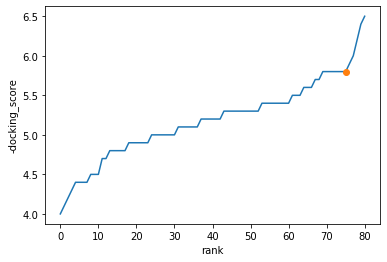

In [65]:
#plt.figure(figsize=(10,7))
scores = np.array([-float(c.split()[1]) for c in cd])
ids = [c.split()[0] for c in cd]
plt.plot(scores)
q = ids.index('1qy1')
plt.plot(q, scores[q], 'o')
plt.xlabel('rank')
plt.ylabel('-docking_score')
plt.savefig('inverse_results.png')

In [60]:
top5 = ids[-5:]
print(top5)
print(len(scores))

['1xvc', '3hl7', '2bys', '3ip0', '1yv3']
81


In [58]:
with open('complexes.list') as f:
    receptors = f.readlines()
pdbcodes = [r[:4].lower() for r in receptors if r[:4].lower() in top5]
chain_ids = [r[4] for r in receptors if r[:4].lower() in top5]
print(pdbcodes)
print(chain_ids)

['1yv3', '1xvc', '3ip0', '2bys', '3hl7']
['A', 'A', 'A', 'J', 'A']


In [59]:
for pdbcode, chain_id in zip(pdbcodes, chain_ids):
    # Download structure:
    receptor = download_and_select(pdbcode, chain_id)
    
    # Run fpocket:
    pockets = client.submit(fpocket, receptor)

    # Find the dimensions of each pocket
    xcs, ycs, zcs, sxs, sys, szs = client.submit(get_dimensions, pockets)

    # Prepare receptor for docking:
    receptor_qt = client.submit(prep_receptor, receptor)


    # Run vina:
    docks, logfiles = client.map(vina, receptor_qt, ligand_qt, xcs.result(), ycs.result(), zcs.result(), sxs.result(), sys.result(), szs.result())

    # Look through the log files for each pocket to find the best:

    best_p, best_a = best_affinity(logfiles)
    print(pdbcode, best_p, best_a)
    docks[best_p].result().save('{}_{}.pdbqt'.format(pdbcode, best_p))

1yv3 0 -6.4
1xvc 0 -5.9
3ip0 0 -6.4
2bys 0 -6.2
3hl7 0 -5.3
